# Parameters

In [4]:
import os
drive_base_dir = ""
window_size = 30
result_file = os.path.join(drive_base_dir, "training_results.csv")
model_path = os.path.join(drive_base_dir, "models")
history_path = os.path.join(drive_base_dir, "histories")

# Function

## Training dataset prepare


In [ ]:
# @title
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][0])
    return np.array(X), np.array(y)
# create sequences for multi-step LSTM
def make_multistep_sequences(data, window_size=30, future_steps=5, index=0):

    X, y = [], []
    for i in range(len(data) - window_size - future_steps + 1):
        X.append(data[i : i + window_size, :])
        y.append(data[i + window_size : i + window_size + future_steps, index])
    return np.array(X), np.array(y)

# create sequence by using column name
def create_sequences_by_feat_name(df, feature_cols, target_col, window_size, future_steps=1):

    missing = [c for c in (feature_cols + [target_col]) if c not in df.columns]
    if missing:
        raise ValueError(f"Non exist columns: {missing}")

    X2D = df[feature_cols].to_numpy(dtype=np.float32)
    y1D = df[target_col].to_numpy(dtype=np.float32) 

    T, F = X2D.shape
    last = T - window_size - future_steps + 1
    

    X = np.empty((last, window_size, F), dtype=np.float32)
    y = np.empty((last, future_steps), dtype=np.float32)

    for i in range(last):
        X[i] = X2D[i:i+window_size]
        y[i] = y1D[i+window_size : i+window_size+future_steps]

    return X, y

## Model Training

### evaluate_model

In [ ]:
from xml.parsers.expat import model
from matplotlib import units
import numpy as np
import os
import json
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import load_model, Sequential
from keras.layers import Layer, LSTM, Dense, Dropout
import keras.backend as K
from keras.metrics import MeanAbsoluteError
from keras.losses import MeanSquaredError
def evaluate_model(y_test,y_pred, scaler=None, title=None, history_path=None):


    if y_test.ndim == 1:
        y_test = y_test[:, None]
        y_pred = y_pred[:, None]
    if scaler:
        min_close, max_close = scaler.data_min_[0], scaler.data_max_[0]
        y_test_plot = y_test * (max_close - min_close) + min_close
        y_pred_plot = y_pred * (max_close - min_close) + min_close
    else:
        y_test_plot = y_test
        y_pred_plot = y_pred

    assert y_test_plot.shape == y_pred_plot.shape
    # Metrics
    mse = mean_squared_error(y_test_plot, y_pred_plot)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_plot, y_pred_plot)
    mape = np.mean(np.abs((y_test_plot - y_pred_plot) / y_test_plot)) * 100
    r2 = r2_score(y_test_plot, y_pred_plot)


    train_loss = val_loss = None
    if history_path:
        with open(history_path, "r") as f:
            history = json.load(f)
        train_loss = history.get("loss", None)
        val_loss = history.get("val_loss", None)


    fig, axes = plt.subplots(3, 1, figsize=(12, 12),
                         gridspec_kw={'height_ratios': [3, 2, 1]})

    # Prediction vs True
    axes[0].plot(y_test_plot, label="True", color="blue")
    axes[0].plot(y_pred_plot, label="Predicted", color="orange")
    axes[0].set_title(title or "Prediction vs True")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Price" if scaler else "Scaled Value")
    axes[0].legend()
    axes[0].grid(True)

    # Loss Curve
    if train_loss and val_loss:
        axes[1].plot(train_loss, label="Train Loss", color="green")
        axes[1].plot(val_loss, label="Validation Loss", color="red")
        axes[1].set_title("Training vs Validation Loss")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].legend()
        axes[1].grid(True)
    else:
        axes[1].text(0.5, 0.5, "No loss history found", fontsize=12, ha='center')
    axes[2].axis("off")                         
    text_str = (
        f"MSE   : {mse:,.2f}\n"
        f"RMSE  : {rmse:,.2f}\n"
        f"MAE   : {mae:,.2f}\n"
        f"MAPE  : {mape:.2f} %\n"
        f"R²    : {r2:.6f}"
    )
    axes[2].text(0.01, 0.9, "Evaluation Metrics", fontsize=14, weight='bold')
    axes[2].text(0.01, 0.5, text_str, fontsize=12, va='top',
                family="monospace")

    plt.tight_layout()
    plt.show()


    return {
        "model": model_path,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

def predict_model_multistep(model_path,
              history_path,
              X_test,
              y_test,
              future_steps=1,
              scaler=None,
              title=None,
              attention=None):



    custom_objects = {
        'mae': MeanAbsoluteError(),
    }

    if attention:
        custom_objects['Attention'] = attention
    model = load_model(model_path, custom_objects=custom_objects)


    y_pred  = model.predict(X_test)
    return y_pred

def evaluate(y_test, y_pred, scaler=None, title=None, history_path=None, future_steps=1):
    print("y_pred.shape:", y_pred.shape)
    print("y_true.shape:", y_test.shape)

    def to_2d(a):
        a = np.asarray(a)
        if a.ndim == 3 and a.shape[-1] == 1:  
            a = a[..., 0]
        if a.ndim == 1:                     
            a = a[:, None]
        assert a.ndim == 2, f"bad shape: {a.shape}"
        return a
    y_test = to_2d(y_test)
    y_pred = to_2d(y_pred)

    if scaler is not None:
        min_close, max_close = scaler.data_min_[0], scaler.data_max_[0]
        y_test_plot = y_test * (max_close - min_close) + min_close
        y_pred_plot = y_pred * (max_close - min_close) + min_close
    else:
        y_test_plot = y_test
        y_pred_plot = y_pred


    Ht, Hp = y_test.shape[1], y_pred.shape[1]
    if Ht != Hp:
        H = min(Ht, Hp)
        print(f"[warn] horizon mismatch: y_true={Ht}, y_pred={Hp} -> using first {H}")
        y_test = y_test[:, :H]
        y_pred = y_pred[:, :H]
    else:
        H = Hp


    mse  = mean_squared_error(y_test_plot, y_pred_plot, multioutput="raw_values")
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_plot, y_pred_plot, multioutput="raw_values")
    eps = 1e-8
    mape = np.mean(
        np.abs((y_test_plot - y_pred_plot) / np.maximum(np.abs(y_test_plot), eps)),
        axis=0
    ) * 100
    r2   = [r2_score(y_test_plot[:, k], y_pred_plot[:, k]) for k in range(future_steps)]


    fig, ax = plt.subplots(figsize=(14, 6))
    show_n = min(500, len(y_test_plot))
    for k in range(future_steps):
        ax.plot(y_test_plot[:show_n, k], label=f"True t+{k+1}")
        ax.plot(y_pred_plot[:show_n, k], "--", label=f"Pred t+{k+1}")
    ax.set_title(title or f"Multi-step Forecast (first {show_n} samples)")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Price" if scaler else "Scaled Value")
    ax.legend(ncol=2); ax.grid(True); plt.show()

    # print("history_path:", history_path)
    if history_path and os.path.exists(history_path):
        with open(history_path, "r") as f:
            hist = json.load(f)
        if "loss" in hist and "val_loss" in hist:
            plt.figure(figsize=(8, 4))
            plt.plot(hist["loss"],     label="Train Loss")
            plt.plot(hist["val_loss"], label="Val Loss")
            plt.title("Training vs Validation Loss")
            plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()
    else:
        print(f"[warn] history not found: {history_path}")

    print(f"{'Step':>4} | {'MSE':>10} {'RMSE':>10} {'MAE':>10} {'MAPE%':>8} {'R²':>6}")
    for k in range(future_steps):
        print(f"{k+1:>4} | {mse[k]:10.4f} {rmse[k]:10.4f} {mae[k]:10.4f} {mape[k]:8.2f} {r2[k]:6.4f}")

    return {
        "mse":  mse.tolist(),
        "rmse": rmse.tolist(),
        "mae":  mae.tolist(),
        "mape": mape.tolist(),
        "r2":   r2
    }

In [ ]:
# Bug exist for multi-step
def evaluate_price_from_return(
    y_test, y_pred,
    scaler_y=None,
    title=None, history_path=None,
    df_segment=None, window_size=None, anchor_col='Close',
    log_return=True, normalize_if_no_anchor=True
):
    import numpy as np, os, json, matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    def to_2d(a):
        a = np.asarray(a)
        if a.ndim == 3 and a.shape[-1] == 1: a = a[..., 0]
        if a.ndim == 1: a = a[:, None]
        assert a.ndim == 2, f"bad shape: {a.shape}"
        return a

    yt = to_2d(y_test)
    yp = to_2d(y_pred)

    if scaler_y is not None:
      if yt.shape[1] > 1 and scaler_y.min_.shape[0] == 1:
          min_ = np.repeat(scaler_y.min_, yt.shape[1])
          scale_ = np.repeat(scaler_y.scale_, yt.shape[1])
          yt = yt * scale_ + min_
          yp = yp * scale_ + min_
      else:
          yt = scaler_y.inverse_transform(yt)
          yp = scaler_y.inverse_transform(yp)

    # Ht, Hp = yt.shape[1], yp.shape[1]
    # H = min(Ht, Hp)
    # if Ht != Hp:
    #     print(f"[warn] horizon mismatch: y_true={Ht}, y_pred={Hp} -> using first {H}")
    #     yt, yp = yt[:, :H], yp[:, :H]

    # N = len(yt)
    
    Ht, Hp = y_test.shape[1], y_pred.shape[1]
    if Ht != Hp:
        H = min(Ht, Hp)
        print(f"[warn] horizon mismatch: y_true={Ht}, y_pred={Hp} -> using first {H}")
        y_test = y_test[:, :H]
        y_pred = y_pred[:, :H]
    else:
        H = Hp

    anchors = None
    if (df_segment is not None) and (window_size is not None):
        closes = np.asarray(df_segment[anchor_col], dtype=np.float32)
        anchors = closes[window_size-1 : window_size-1 + N]
        if len(anchors) != N:
            raise ValueError(f"anchors length {len(anchors)} != samples {N}. "
                             f"Check df_segment length/window_size.")
    elif normalize_if_no_anchor:
        anchors = np.ones(N, dtype=np.float32) 
        print("No anchors provided; using normalized price index (start=1.0).")
    else:
        raise ValueError("No anchors. Pass df_segment+window_size, "
                         "or set normalize_if_no_anchor=True.")

    if log_return:
        cumr = np.cumsum(yt, axis=1);  y_true_price = anchors[:, None] * np.exp(cumr)
        cumr = np.cumsum(yp, axis=1);  y_pred_price = anchors[:, None] * np.exp(cumr)
    else:
        y_true_price = anchors[:, None] * np.cumprod(1 + yt, axis=1)
        y_pred_price = anchors[:, None] * np.cumprod(1 + yp, axis=1)

    mse  = mean_squared_error(y_true_price, y_pred_price, multioutput="raw_values")
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true_price, y_pred_price, multioutput="raw_values")
    eps  = 1e-8
    mape = np.mean(np.abs((y_true_price - y_pred_price) / (np.abs(y_true_price) + eps)), axis=0) * 100
    r2   = [r2_score(y_true_price[:, k], y_pred_price[:, k]) for k in range(H)]


    show_n = min(1500, len(y_true_price))
    plt.figure(figsize=(14,6))
    for k in range(H):
        plt.plot(y_true_price[:show_n, k], label=f"True Price t+{k+1}")
        plt.plot(y_pred_price[:show_n, k], '--', label=f"Pred Price t+{k+1}")
    plt.title(title or f"Price forecast (first {show_n})")
    plt.xlabel("Sample Index"); plt.ylabel("Price")
    plt.legend(ncol=2); plt.grid(True); plt.show()

    print(f"{'Step':>4} | {'MSE':>12} {'RMSE':>10} {'MAE':>10} {'MAPE%':>8} {'R²':>7}")
    for k in range(H):
        print(f"{k+1:>4} | {mse[k]:12.6f} {rmse[k]:10.6f} {mae[k]:10.6f} {mape[k]:8.2f} {r2[k]:7.4f}")

    return {
        "mse":  mse.tolist(), "rmse": rmse.tolist(), "mae": mae.tolist(),
        "mape": mape.tolist(), "r2": r2,
        "y_true_price": y_true_price, "y_pred_price": y_pred_price,
    }


### train_and_save_model

In [ ]:
import os
import json
import csv
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import numpy as np

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                    shape=(input_shape[-1], 1),
                    initializer='glorot_uniform',
                    trainable=True)
        self.b = self.add_weight(name='att_bias',
                    shape=(input_shape[1], 1),
                    initializer='zeros',
                    trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

def train_and_save_model(X_train, y_train,
            X_val, y_val,
            model_index=0,
            layers=1,
            units=64,
            dropout_rate=0.2,
            batch_size=32,
            epochs=40,
            window_size=30,
            future_steps=1,
            optimizer='adam',
            callbacks=None,
            result_file=None,
            attention=None,
            loss_function='mae',
            note=None):
    if callbacks is not None and not isinstance(callbacks, (list, tuple)):
            callbacks = [callbacks]

    model = Sequential()


    if layers >= 1:
        model.add(LSTM(units, return_sequences=(layers > 1 or attention is not None),
                        input_shape=(window_size, X_train.shape[2])))
        if dropout_rate > 0: model.add(Dropout(dropout_rate))

    for _ in range(1, layers-1):
        model.add(LSTM(units, return_sequences=True))
        if dropout_rate > 0: model.add(Dropout(dropout_rate))


    if layers > 1:
        rs = True if attention is not None else False
        model.add(LSTM(units, return_sequences=rs))
        if dropout_rate > 0: model.add(Dropout(dropout_rate))

    if attention is not None:
        model.add(attention)

    model.add(Dense(future_steps))

    model.compile(optimizer=optimizer, loss=loss_function, metrics=['mae'])

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=callbacks
    )
    
  # Generate file names and paths
    model_name = f"model_{model_index}_layers{layers}_units{units}_with_attention.h5"
    history_name = f"history_{model_index}.json"
    model_path = os.path.join("models", model_name)
    history_path = os.path.join("histories", history_name)

    os.makedirs("models", exist_ok=True)
    os.makedirs("histories", exist_ok=True)

    try:
        # Save model
        model.save(model_path)

        # Save training history
        with open(history_path, "w") as f:
            json.dump(
                {k: [float(x) for x in v] for k, v in history.history.items()},
                f
            )

        # Get best validation loss
        min_val_loss = min(history.history["val_loss"])

        # Write result to CSV
        result_file = "training_results.csv"
        write_header = not os.path.exists(result_file)

        with open(result_file, "a", newline="") as csvfile:
            writer = csv.writer(csvfile)
            if write_header:
                writer.writerow([
                    "index","lstm_units", "num_layers", "dropout", "batch_size", "epochs",
                    "optimizer", "model_name", "val_loss", "history_path"
                ])
            writer.writerow([
                model_index,units, layers, dropout_rate, batch_size,
                epochs, "adam", model_name, min_val_loss, history_name
            ])

    except Exception as e:
        print("History sample:", {k: v[:2] for k, v in history.history.items()})
        print("Error during save or logging:", e)
        import traceback
        traceback.print_exc()

    return model, history

# Data Preprocessing

<Axes: title={'center': 'Bitcoin Close Price'}, xlabel='Timestamp'>

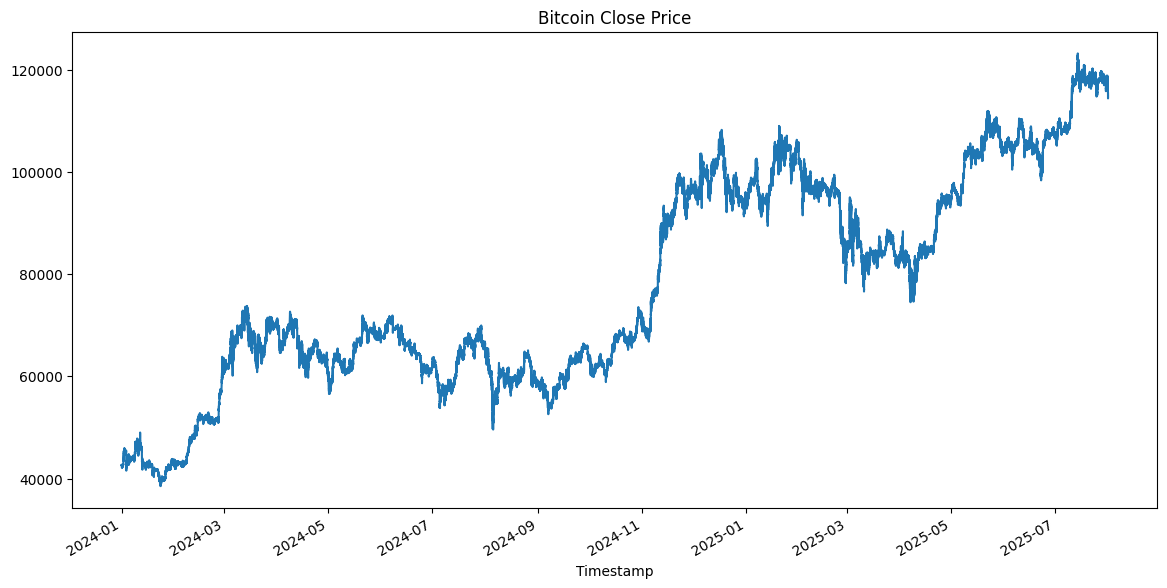

In [9]:
import pandas as pd
from datetime import datetime
import sys
import os

data_path = "../data/btcusd_1-min_data.csv"

bitstamp = pd.read_csv(data_path)
bitstamp['Timestamp'] = pd.to_datetime(bitstamp['Timestamp'], unit='s')
bitstamp.set_index('Timestamp', inplace=True)

bitstamp = bitstamp[(bitstamp.index >= '2024-01-01') & (bitstamp.index <= bitstamp.index[-1])]
bitstamp.Close.plot(figsize=(14,7), title="Bitcoin Close Price")

Missing values in the dataset:
Missing timestamps: 1160
DatetimeIndex(['2025-03-15 00:01:00', '2025-03-15 00:02:00',
               '2025-03-15 00:03:00', '2025-03-15 00:04:00',
               '2025-03-15 00:05:00', '2025-03-15 00:06:00',
               '2025-03-15 00:07:00', '2025-03-15 00:08:00',
               '2025-03-15 00:09:00', '2025-03-15 00:10:00'],
              dtype='datetime64[ns]', freq='min')


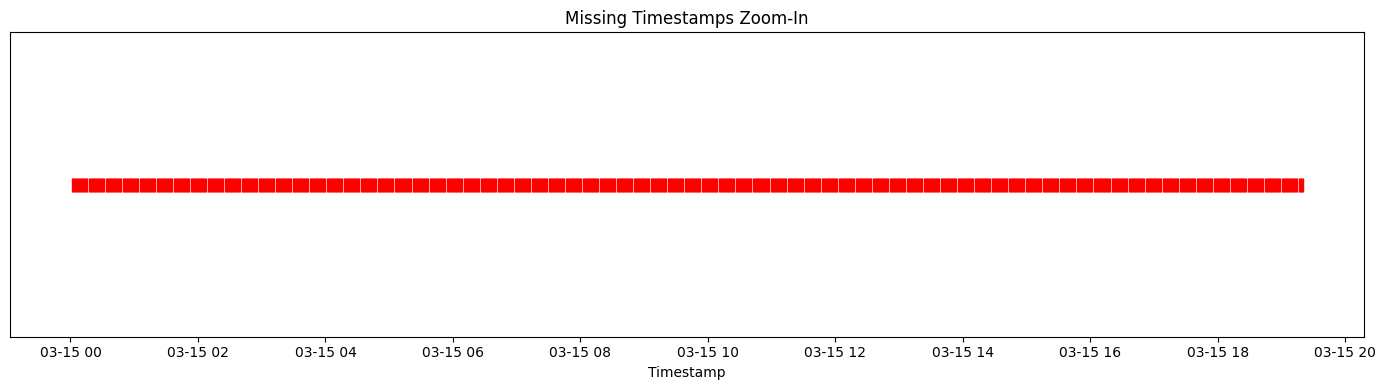

In [10]:
import matplotlib.pyplot as plt

# find missing values by checking for NaN values
missing_values = bitstamp.isnull().sum()
missing_per = (missing_values/bitstamp.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True)
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

# display the missing values
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp.index.min(), end=bitstamp.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])

# Plotting the missing timestamps
missing_df = pd.DataFrame(index=missing_times)
missing_df['Missing'] = 1
plt.figure(figsize=(14, 4))
plt.plot(missing_df.index, missing_df['Missing'], '|', color='red', markersize=10)
plt.title("Missing Timestamps Zoom-In")
plt.xlabel("Timestamp")
plt.yticks([])
plt.tight_layout()
plt.show()

C:\Users\jiang\AppData\Local\Temp\ipykernel_25604\3003282590.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method=method)


Missing values in the dataset:
Missing timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='min')
                         Open      High       Low     Close    Volume
Timestamp                                                            
2025-08-01 00:55:00  115031.0  115180.0  115031.0  115077.0  4.551279
2025-08-01 00:56:00  115107.0  115258.0  115107.0  115258.0  4.916915
2025-08-01 00:57:00  115258.0  115271.0  115209.0  115271.0  0.950385
2025-08-01 00:58:00  115271.0  115410.0  115271.0  115410.0  5.030814
2025-08-01 00:59:00  115410.0  115464.0  115409.0  115425.0  2.373751


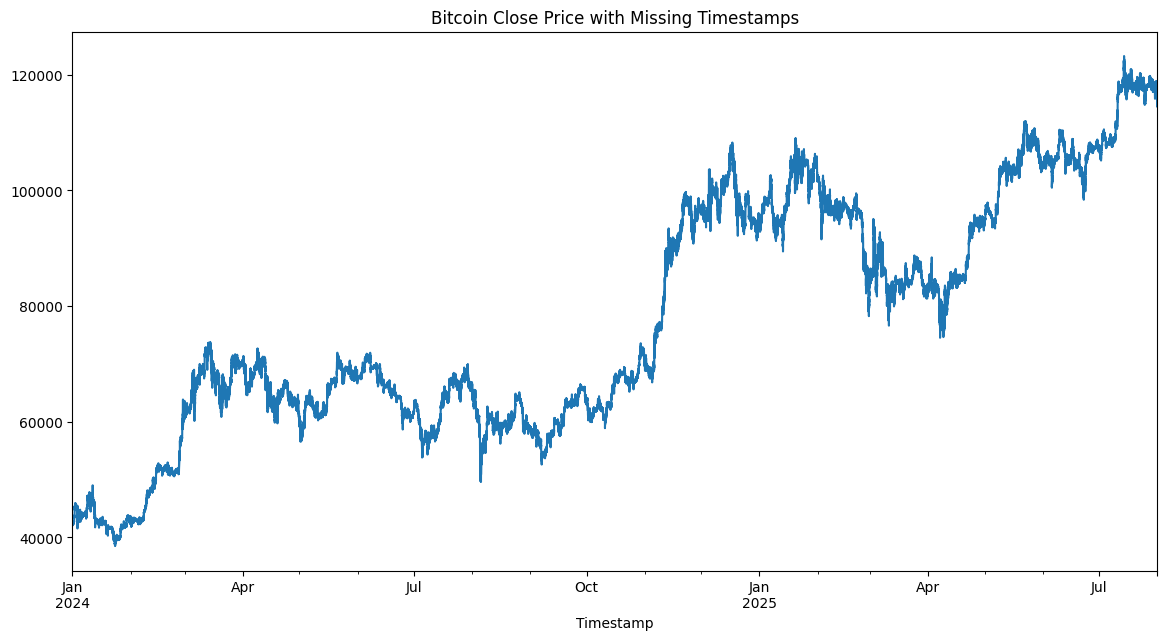

In [11]:
def add_missing_timestamps(df: pd.DataFrame, freq='1min'):
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    df_full = df.reindex(full_index)
    df_full.index.name = 'Timestamp'
    return df_full

# Function to fill missing values in the DataFrame using forward fill method.
# This method propagates the last valid observation forward to fill gaps.
def fill_missing_values(df: pd.DataFrame, method='ffill') -> pd.DataFrame:
    return df.fillna(method=method)


bitstamp_full = add_missing_timestamps(bitstamp, freq='1min')
# Plotting the Close price with missing timestamps
bitstamp_full['Close'].plot(figsize=(14, 7), title="Bitcoin Close Price with Missing Timestamps")

# using forward fill to fill the missing values
bitstamp_filled = fill_missing_values(bitstamp_full, method='ffill')

# display the missing values after filling
print("Missing values in the dataset:")
expected_range = pd.date_range(start=bitstamp_filled.index.min(), end=bitstamp_filled.index.max(), freq='1min')
missing_times = expected_range.difference(bitstamp_filled.index)
print("Missing timestamps:", len(missing_times))
print(missing_times[:10])
print(bitstamp_filled.tail())

<Figure size 1200x900 with 0 Axes>

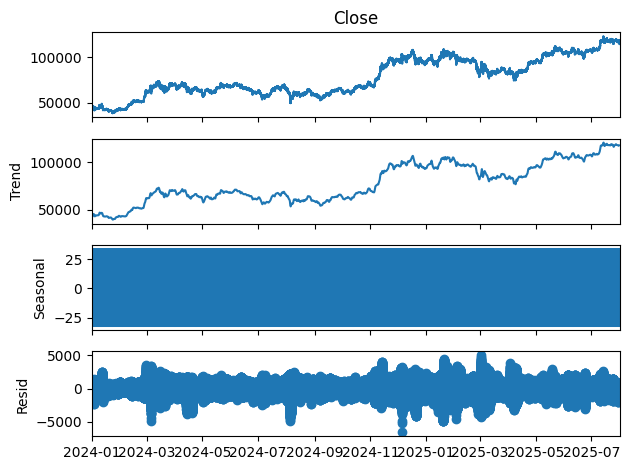

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = bitstamp_filled['Close'].copy()

ts = ts.resample('1min').mean()

decomp_result = seasonal_decompose(ts, model='additive', period=1440)

trend = decomp_result.trend
seasonal = decomp_result.seasonal
residual = decomp_result.resid

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
decomp_result.plot()
plt.tight_layout()
plt.show()

# Model Training

## Single-step LSTM Model

### Single step LSTM with simple feature

In [39]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

WINDOW_SIZE = 30
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2

df = bitstamp_filled.copy()
features = df[['Close', 'Volume']].values

n_total = len(features)
n_train = int(n_total * TRAIN_RATIO)

train_features = features[:n_train]
test_features = features[n_train:]

# data
scaler = MinMaxScaler()
scaler.fit(train_features)

scaled_train = scaler.transform(train_features)
scaled_test = scaler.transform(test_features)


X_train_all, y_train_all = create_sequences(scaled_train, WINDOW_SIZE)
X_test, y_test = create_sequences(scaled_test, WINDOW_SIZE)

n_val = int(len(X_train_all) * VAL_RATIO)
X_val = X_train_all[-n_val:]
y_val = y_train_all[-n_val:]
X_train = X_train_all[:-n_val]
y_train = y_train_all[:-n_val]

print("Train scaled range:", X_train_all.min(), X_train_all.max())
print("Test scaled range:", X_test.min(), X_test.max())

Train scaled range: 0.0 1.0
Test scaled range: 0.0 1.2013384754990926


In [19]:
import csv
import json
from keras.callbacks import EarlyStopping
import os
import tensorflow as tf
model_index = 201
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                    shape=(input_shape[-1], 1),
                    initializer='glorot_uniform',
                    trainable=True)
        self.b = self.add_weight(name='att_bias',
                    shape=(input_shape[1], 1),
                    initializer='zeros',
                    trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.math.tanh(tf.linalg.matmul(x, self.W) + self.b)
        a = tf.math.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)


model, history = train_and_save_model(
    X_train, y_train,
    X_val, y_val,
    model_index=model_index,
    layers=1,
    units=64,
    dropout_rate=0.2,
    batch_size=32,
    epochs=40,
    window_size=window_size,
    callbacks = [EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True),],
    attention=Attention(),
    result_file = result_file,
    note="Single-step_LSTM_with_simple_feature_with_attention")


Epoch 1/40
16647/16647 [==============================] - 85s 5ms/step - loss: 0.0042 - mae: 0.0042 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 2/40
16647/16647 [==============================] - 81s 5ms/step - loss: 0.0027 - mae: 0.0027 - val_loss: 0.0032 - val_mae: 0.0032
Epoch 3/40
16647/16647 [==============================] - 76s 5ms/step - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 4/40
16647/16647 [==============================] - 69s 4ms/step - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0022 - val_mae: 0.0022
Epoch 5/40
16647/16647 [==============================] - 75s 5ms/step - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 6/40
16647/16647 [==============================] - 74s 4ms/step - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0041 - val_mae: 0.0041
Epoch 7/40
16647/16647 [==============================] - 75s 5ms/step - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 8/40
16647/16647 [=================

In [48]:
import tensorflow as tf

result_file = "training_results.csv"
df = pd.read_csv(result_file)
df.set_index("index", inplace=True)
target_indices = [201]

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                    shape=(input_shape[-1], 1),
                    initializer='glorot_uniform',
                    trainable=True)
        self.b = self.add_weight(name='att_bias',
                    shape=(input_shape[1], 1),
                    initializer='zeros',
                    trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.math.tanh(tf.linalg.matmul(x, self.W) + self.b)
        a = tf.math.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

results = []
for i in target_indices:
    if i not in df.index:
      print(f"index {i} not exist")
      continue
    row = df.loc[i]
    model_file_path = f"{model_path}/{row['model_name']}"
    history_file_path = f"{history_path}/{row['history_path']}"
    print(f"Evaluating {model_file_path} ...")

    result = predict_model_multistep(
        model_path=model_file_path,
        history_path=history_file_path,
        X_test=X_test,
        y_test=y_test,
        scaler=scaler,
        title=f"Model {i} ({row['model_name']})",
        attention=Attention()
    )

    results.append(
        {
            "index": i,
            "model_name": row["model_name"],
            "result": result,
            "history": row["history_path"]
        }
      )


Evaluating models/model_201_layers1_units64_with_attention.h5 ...
5202/5202 [==============================] - 8s 1ms/step


y_pred.shape: (166446, 1)
y_true.shape: (166446,)


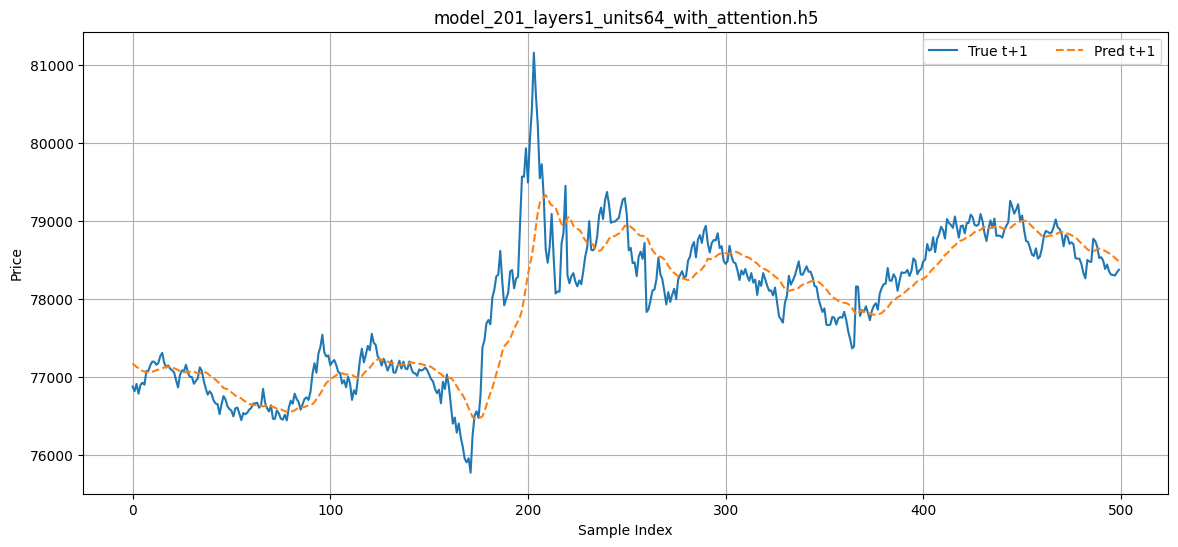

Step |        MSE       RMSE        MAE    MAPE%     R²
   1 | 22218.8332   149.0598   102.5393     0.00 0.9998


In [49]:
for r in results:
  evaluate(y_test, r["result"], scaler=scaler, title=r["model_name"], history_path=r["history"])

## Multi-step LSTM with simple feature

In [16]:
df = bitstamp_filled.copy()
# df = df[(df.index >= '2024-08-01') & (df.index <= df.index[-1])]

n_total = len(features)
n_train = int(n_total * TRAIN_RATIO)

train_features = features[:n_train]
test_features = features[n_train:]

# data
scaler = MinMaxScaler()
scaler.fit(train_features)

scaled_train = scaler.transform(train_features)
scaled_test = scaler.transform(test_features)


X_train_all, y_train_all = make_multistep_sequences(scaled_train, WINDOW_SIZE, future_steps=5, index=0)
X_test, y_test = make_multistep_sequences(scaled_test, WINDOW_SIZE, future_steps=5, index=0)

n_val = int(len(X_train_all) * VAL_RATIO)
X_val = X_train_all[-n_val:]
y_val = y_train_all[-n_val:]
X_train = X_train_all[:-n_val]
y_train = y_train_all[:-n_val]

print("Train scaled range:", X_train_all.min(), X_train_all.max())
print("Test scaled range:", X_test.min(), X_test.max())

Train scaled range: 0.0 1.0
Test scaled range: 0.0 1.2013384754990926


In [ ]:
import csv
import json
from keras.callbacks import EarlyStopping
import os
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
model_index = 202

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                    shape=(input_shape[-1], 1),
                    initializer='glorot_uniform',
                    trainable=True)
        self.b = self.add_weight(name='att_bias',
                    shape=(input_shape[1], 1),
                    initializer='zeros',
                    trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

model, history = train_and_save_model(
    X_train, y_train,
    X_val, y_val,
    model_index=model_index,
    layers=1,
    units=64,
    dropout_rate=0.2,
    batch_size=32,
    epochs=40,
    window_size=window_size,
    future_steps=5,
    callbacks = [EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True),reduce_lr],
    result_file = result_file,
    note="Multi-step_LSTM_with_simple_feature")

In [17]:
import tensorflow as tf
df = pd.read_csv(result_file)
df.set_index("index", inplace=True)
target_indices = [202]



results = []


for i in target_indices:
    if i not in df.index:
      print(f"index {i} not exist")
      continue
    row = df.loc[i]
    model_file_path = f"{model_path}/{row['model_name']}"
    history_file_path = f"{history_path}/{row['history_path']}"
    print(f"Evaluating {model_file_path} ...")
    result = predict_model_multistep(
        model_path=model_file_path,
        history_path=history_file_path,
        X_test=X_test,
        y_test=y_test,
        scaler=scaler,
        title=f"Model {i} ({row['model_name']})",
        attention=None,
        future_steps=5
    )

    results.append(
        {
            "index": i,
            "model_name": row["model_name"],
            "result": result,
            "history": row["history_path"]
        }
      )


Evaluating models/model_202_layers1_units64_with_attention.h5 ...
5202/5202 [==============================] - 7s 1ms/step


y_pred.shape: (166442, 5)
y_true.shape: (166442, 5)


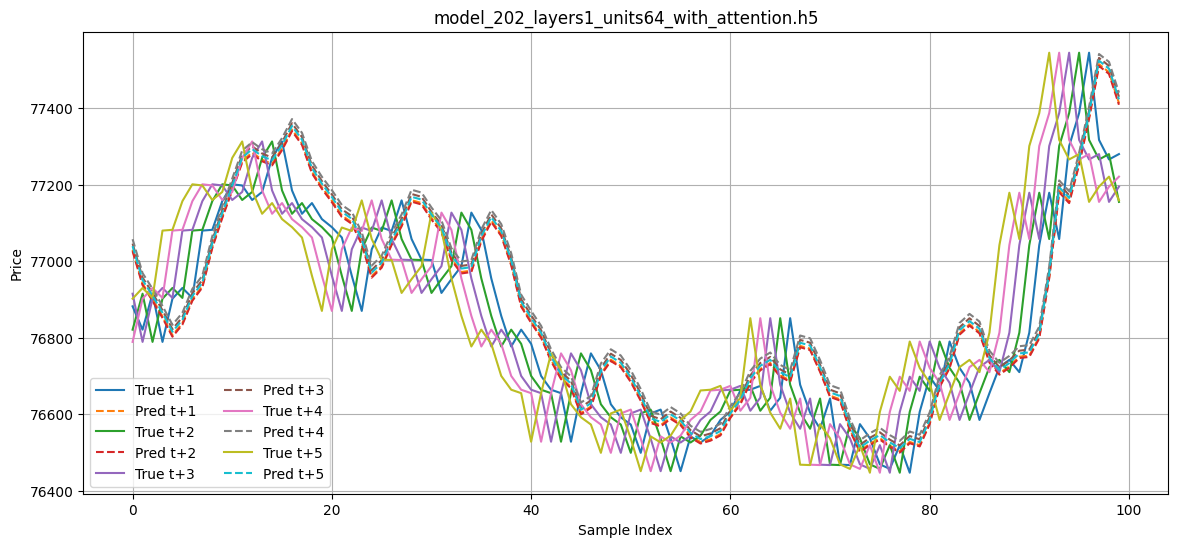

Step |        MSE       RMSE        MAE    MAPE%     R²
   1 | 10282.3763   101.4021    85.1748     0.00 0.9999
   2 |  9450.4515    97.2134    72.6406     0.00 0.9999
   3 | 24756.5828   157.3422   133.9559     0.00 0.9998
   4 | 23299.7749   152.6426   124.0027     0.00 0.9998
   5 | 29504.6526   171.7692   140.3770     0.00 0.9997


In [18]:
for r in results:
  evaluate(y_test, r["result"], scaler=scaler, title=r["model_name"], history_path=r["history"], future_steps=5)

## Feature Engineering

In [80]:
!pip install ta
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
df = bitstamp_filled.copy()
df = df[(df.index >= '2020-01-01') & (df.index <= df.index[-1])]

df['return'] = np.log(df['Close'] / df['Close'].shift(1))
df['price_delta'] = df['Close'] - df['Close'].shift(1)
df['hl_spread'] = df['High'] - df['Low']
df['tr'] = np.maximum(
    df['High'] - df['Low'],
    np.maximum(
        abs(df['High'] - df['Close'].shift(1)),
        abs(df['Low'] - df['Close'].shift(1))
    )
)
df['vol_change'] = df['Volume'].pct_change()
df['rsi'] = RSIIndicator(close=df['Close'], window=14).rsi()
df['ema20'] = EMAIndicator(close=df['Close'], window=20).ema_indicator()
df['std_60min'] = df['Close'].rolling(window=30).std()
df["volatility"] = df["return"].rolling(window=WINDOW_SIZE).std()



In [81]:
def add_lags(d, cols, lags=(1,2,3)):
    for c in cols:
        for L in lags:
            d[f'{c}_lag{L}'] = d[c].shift(L)
    return d

lag_cols = ['return','price_delta','vol_change','rsi','ema20']
df = add_lags(df, lag_cols, lags=(1,2,3))

target_step = 1
df['y'] = df['return'].shift(target_step*-1)


df = df.dropna().reset_index(drop=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
feature_cols = [
    'return','price_delta','hl_spread','tr','vol_change','rsi','ema20',
    'std_60min','volatility',
    'return_lag1','return_lag2','return_lag3',
    'price_delta_lag1','price_delta_lag2','price_delta_lag3',
    'vol_change_lag1','vol_change_lag2','vol_change_lag3',
    'rsi_lag1','rsi_lag2','rsi_lag3',
    'ema20_lag1','ema20_lag2','ema20_lag3'
]

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Clean the DataFrame by dropping rows with NaN in any of the feature columns or target column
all_cols = feature_cols + ['y']    
before = len(df)
df = df.dropna(subset=all_cols).reset_index(drop=True)
after = len(df)
print(f"dropped rows: {before - after}")


X = df[feature_cols].astype(np.float32).values
y = df['y'].astype(np.float32).values


assert np.isfinite(X).all(), "X still has non-finite values"
assert np.isfinite(y).all(), "y still has non-finite values"
print("X/y are clean:", X.shape, y.shape)

n = len(df)
split = int(n * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

split2 = int(len(X_train) * 0.9)
X_tr, X_val = X_train[:split2], X_train[split2:]
y_tr, y_val = y_train[:split2], y_train[split2:]




dropped rows: 59842
X/y are clean: (760295, 24) (760295,)


In [56]:
import xgboost as xgb
params = dict(
    objective='reg:squarederror',
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    tree_method='hist',
    eval_metric='rmse',
    early_stopping_rounds=100


)

model = xgb.XGBRegressor(**params)
model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False,
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,'rmse'


In [57]:
import sklearn, numpy as np
import shap
def eval_and_print(y_true, y_pred, title=""):
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    mse  = mean_squared_error(y_true, y_pred)  
    rmse = np.sqrt(mse)                        
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"{title} RMSE={rmse:.6f}  MAE={mae:.6f}  R2={r2:.4f}")
    return rmse, mae, r2



y_pred_test = model.predict(X_test)
base_scores = eval_and_print(y_test, y_pred_test, title="[Base]")

[Base] RMSE=0.000472  MAE=0.000301  R2=-0.0002


c:\Users\jiang\miniconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Top 15 features by mean |SHAP|:
             feature  mean_abs_shap
0             return   2.102890e-06
1                rsi   7.717596e-07
2   price_delta_lag1   6.172627e-07
3         ema20_lag3   6.163001e-07
4        price_delta   4.680271e-07
5   price_delta_lag2   4.432069e-07
6        return_lag1   3.723579e-07
7        return_lag3   3.152314e-07
8   price_delta_lag3   2.601880e-07
9                 tr   2.268166e-07
10         std_60min   1.686243e-07
11        volatility   1.673499e-07
12        vol_change   1.559712e-07
13          rsi_lag2   1.493607e-07
14        ema20_lag1   1.421834e-07


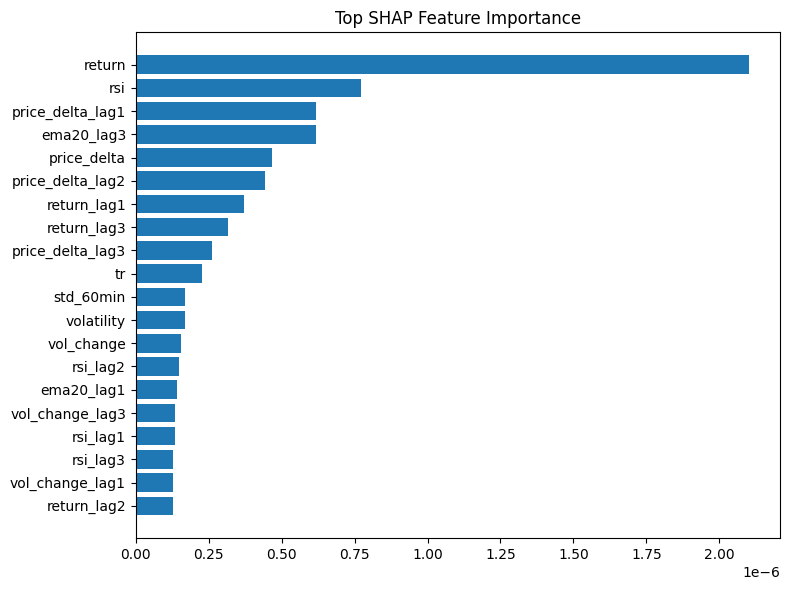

[Top-12] RMSE=0.000472  MAE=0.000301  R2=0.0002

Compare (RMSE, MAE, R2):
Base : (0.00047230335390002504, 0.0003011585504282266, -0.0002294778823852539)
Top-12: (0.0004722026071741232, 0.00030116873676888645, 0.0001971721649169922)


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)   
mean_abs_shap = np.abs(shap_values).mean(axis=0)

importance = pd.DataFrame({
    'feature': feature_cols,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print("\nTop 15 features by mean |SHAP|:")
print(importance.head(15))


plt.figure(figsize=(8, 6))
order = importance['feature'].values[:20][::-1]
vals  = importance['mean_abs_shap'].values[:20][::-1]
plt.barh(order, vals)
plt.title("Top SHAP Feature Importance")
plt.tight_layout()
plt.show()


K = 12 
topk_features = importance['feature'].head(K).tolist()
feat_idx = [feature_cols.index(f) for f in topk_features]

X_train_k = X_train[:, feat_idx]
X_test_k  = X_test[:, feat_idx]
X_tr_k, X_val_k = X_tr[:, feat_idx], X_val[:, feat_idx]

model_k = xgb.XGBRegressor(**params)
model_k.fit(X_tr_k, y_tr, eval_set=[(X_val_k, y_val)],
           verbose=False)

y_pred_k = model_k.predict(X_test_k)
topk_scores = eval_and_print(y_test, y_pred_k, title=f"[Top-{K}]")

print("\nCompare (RMSE, MAE, R2):")
print("Base :", base_scores)
print(f"Top-{K}:", topk_scores)



In [59]:
corr_df = pd.DataFrame(X_train, columns=feature_cols).corr().abs()
to_drop = set()
thr = 0.95
for i in range(len(feature_cols)):
    if feature_cols[i] in to_drop:
        continue
    for j in range(i+1, len(feature_cols)):
        if corr_df.iat[i, j] > thr:
            to_drop.add(feature_cols[j])

reduced_feats = [f for f in feature_cols if f not in to_drop]
idx2 = [feature_cols.index(f) for f in reduced_feats]

X_tr_r, X_val_r = X_tr[:, idx2], X_val[:, idx2]
X_train_r, X_test_r = X_train[:, idx2], X_test[:, idx2]

model_r = xgb.XGBRegressor(**params)
model_r.fit(X_tr_r, y_tr, eval_set=[(X_val_r, y_val)],
             verbose=False)

y_pred_r = model_r.predict(X_test_r)
reduced_scores = eval_and_print(y_test, y_pred_r, title="[Reduced corr]")

print("\nFeatures removed by correlation pruning (>0.95):", sorted(list(to_drop)))
print("Kept features:", reduced_feats)

[Reduced corr] RMSE=0.000472  MAE=0.000301  R2=0.0001

Features removed by correlation pruning (>0.95): ['ema20_lag1', 'ema20_lag2', 'ema20_lag3', 'price_delta', 'price_delta_lag1', 'price_delta_lag2', 'price_delta_lag3', 'tr']
Kept features: ['return', 'hl_spread', 'vol_change', 'rsi', 'ema20', 'std_60min', 'volatility', 'return_lag1', 'return_lag2', 'return_lag3', 'vol_change_lag1', 'vol_change_lag2', 'vol_change_lag3', 'rsi_lag1', 'rsi_lag2', 'rsi_lag3']


In [60]:
features = df[reduced_feats].values
print(features)

[[ 4.69538687e-04  2.00000000e+01 -3.06644881e-01 ...  3.91471064e+01
   4.01495483e+01  4.32335685e+01]
 [ 2.11220503e-04  7.00000000e+00  2.69570433e-01 ...  4.63587189e+01
   3.91471064e+01  4.01495483e+01]
 [-7.04018774e-05  5.00000000e+00 -4.28445934e-01 ...  4.92720869e+01
   4.63587189e+01  3.91471064e+01]
 ...
 [ 4.69361156e-04  1.49000000e+02 -8.05321714e-01 ...  4.23669739e+01
   3.11645312e+01  1.64291848e+01]
 [ 1.57162426e-03  1.51000000e+02  8.03371528e-02 ...  4.41125960e+01
   4.23669739e+01  3.11645312e+01]
 [ 1.12784075e-04  6.20000000e+01 -8.06711156e-01 ...  4.96206803e+01
   4.41125960e+01  4.23669739e+01]]


## Single-step LSTM with more feature

In [52]:
# feature_col = ['Close','return', 'hl_spread', 'vol_change', 'rsi', 'ema20', 'std_60min', 'volatility', 'return_lag1', 'return_lag2', 'return_lag3', 'vol_change_lag1', 'vol_change_lag2', 'vol_change_lag3', 'rsi_lag1', 'rsi_lag2', 'rsi_lag3']

feature_col = ['Close','return', 'hl_spread', 'vol_change', 'rsi', 'ema20', 'std_60min', 'volatility']

missing = [c for c in feature_col if c not in df.columns]
print("Missing:", missing)

print(features.shape)

features = df[feature_col].values
n = len(df)
test_start = int(n * 0.80)
train_end  = int(test_start * 0.80)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=feature_cols + ['y'], inplace=True)
df.reset_index(drop=True, inplace=True)

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:test_start].copy()
df_test  = df.iloc[test_start:].copy()

scaler_x = MinMaxScaler(feature_range=(0, 1)).fit(df_train[feature_col])
# scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(df_train[['return']])

for d in (df_train, df_val, df_test):
    d[feature_col] = scaler_x.transform(d[feature_col])

X_train_all, y_train_all = create_sequences_by_feat_name(
    df_train, feature_cols=feature_col, target_col='Close',
    window_size=WINDOW_SIZE, future_steps=1
)
X_val_all, y_val_all = create_sequences_by_feat_name(
    df_val, feature_cols=feature_col, target_col='Close',
    window_size=WINDOW_SIZE, future_steps=1
)
X_test_all, y_test_all = create_sequences_by_feat_name(
    df_test, feature_cols=feature_col, target_col='Close',
    window_size=WINDOW_SIZE, future_steps=1
)

print("Train scaled range:", X_train_all.min(), X_train_all.max())
print("Test scaled range:", X_test_all.min(), X_test_all.max())

Missing: []
(832380, 2)
Train scaled range: 0.0 1.0
Test scaled range: -0.0010864757 1.214425


In [ ]:
import csv
import json
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import tensorflow as tf
from keras.layers import Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                    shape=(input_shape[-1], 1),
                    initializer='glorot_uniform',
                    trainable=True)
        self.b = self.add_weight(name='att_bias',
                    shape=(input_shape[1], 1),
                    initializer='zeros',
                    trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.math.tanh(tf.linalg.matmul(x, self.W) + self.b)
        a = tf.math.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)
model_index = 206
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
model, history = train_and_save_model(
    X_train_all, y_train_all,
    X_val_all, y_val_all,
    model_index=model_index,
    layers=1,
    units=64,
    dropout_rate=0.2,
    batch_size=32,
    epochs=40,
    window_size=window_size,
    callbacks = [EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True),reduce_lr],
    result_file = result_file,
    attention=Attention(),
    future_steps=1,
    note="Single-step_LSTM_with_more_feature")

In [53]:
import tensorflow as tf
train_res = pd.read_csv(result_file)
train_res.set_index("index", inplace=True)
target_indices = [206]


results = []


for i in target_indices:
    if i not in train_res.index:
      print(f"index {i} not exist")
      continue
    row = train_res.loc[i]
    model_file_path = f"{model_path}/{row['model_name']}"
    history_file_path = f"{history_path}/{row['history_path']}"
    print(f"Evaluating {model_file_path} ...")
    result = predict_model_multistep(
        model_path=model_file_path,
        history_path=history_file_path,
        X_test=X_test_all,
        y_test=y_test_all,
        scaler=scaler,
        title=f"Model {i} ({row['model_name']})",
        attention=Attention(),
    )

    results.append(
        {
            "index": i,
            "model_name": row["model_name"],
            "result": result,
            "history": row["history_path"]
        }
      )

Evaluating models/model_206_layers1_units64_with_attention.h5 ...
4751/4751 [==============================] - 7s 1ms/step


y_pred.shape: (152029, 1)
y_true.shape: (152029, 1)


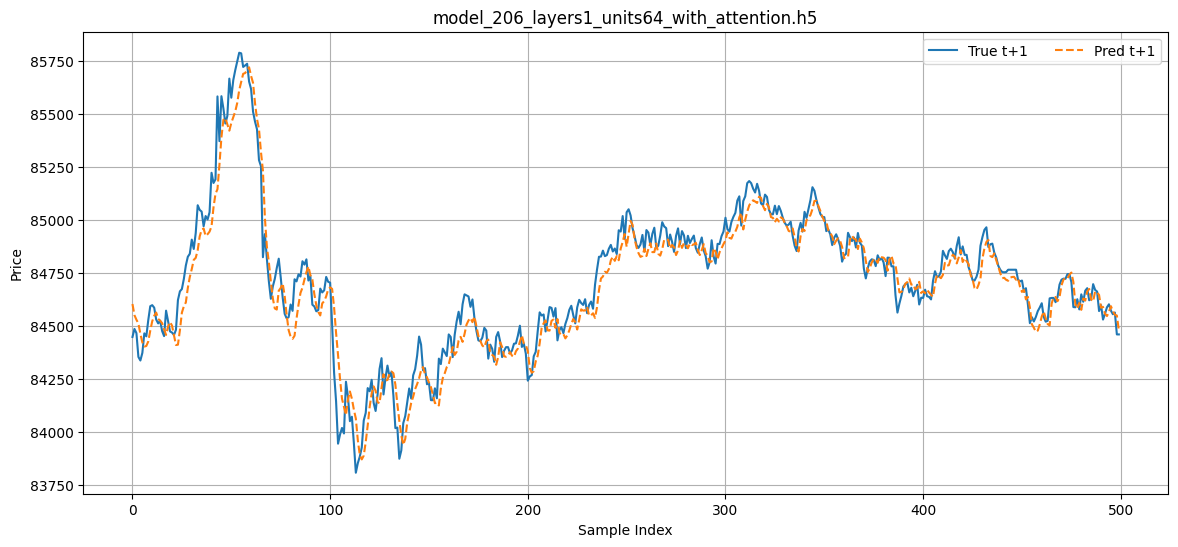

history_path: g:\ML\ML_Project\Bitcoin_Price_Prediction\notebooks\histories\history_206.json


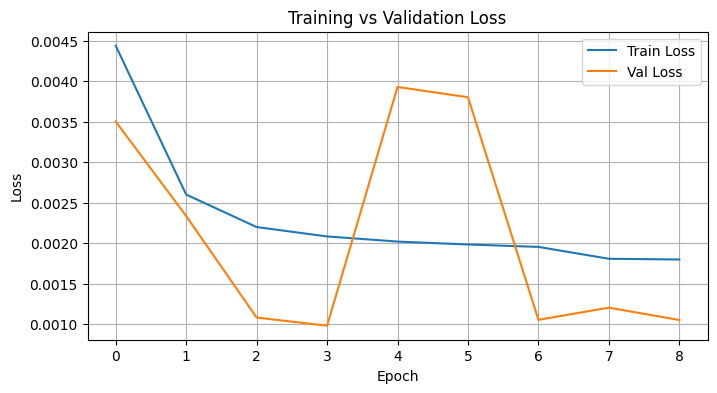

Step |        MSE       RMSE        MAE    MAPE%     R²
   1 |  4814.7729    69.3886    49.4444     0.05 0.9999


In [75]:
import os
for r in results:
    base_dir = os.getcwd()
    history_path = os.path.join(base_dir, "histories", r["history"])
    evaluate(y_test_all, r["result"], scaler=scaler_x, title=r["model_name"], history_path=history_path, future_steps=1)

## Multi-step LSTM with more feature

In [82]:
X_train_all, y_train_all = create_sequences_by_feat_name(
    df_train, feature_cols=feature_col, target_col='Close',
    window_size=WINDOW_SIZE, future_steps=5
)
X_val_all, y_val_all = create_sequences_by_feat_name(
    df_val, feature_cols=feature_col, target_col='Close',
    window_size=WINDOW_SIZE, future_steps=5
)
X_test_all, y_test_all = create_sequences_by_feat_name(
    df_test, feature_cols=feature_col, target_col='Close',
    window_size=WINDOW_SIZE, future_steps=5
)

print("Train scaled range:", X_train_all.min(), X_train_all.max())
print("Test scaled range:", X_test_all.min(), X_test_all.max())

Train scaled range: 0.0 1.0
Test scaled range: -0.0010864757 1.214425


In [33]:
import csv
import json
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

model_index = 204
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)
model, history = train_and_save_model(
    X_train_all, y_train_all,
    X_val_all, y_val_all,
    model_index=model_index,
    layers=1,
    units=64,
    dropout_rate=0.2,
    batch_size=32,
    epochs=40,
    window_size=window_size,
    callbacks = [EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True),reduce_lr],
    result_file = result_file,
    future_steps=5,
    attention=Attention(),
    note="Multi-step_LSTM_with_more_feature")

Epoch 1/40
15205/15205 [==============================] - 62s 4ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0041 - val_mae: 0.0041 - lr: 0.0010
Epoch 2/40
15205/15205 [==============================] - 61s 4ms/step - loss: 0.0026 - mae: 0.0026 - val_loss: 0.0019 - val_mae: 0.0019 - lr: 0.0010
Epoch 3/40
15205/15205 [==============================] - 60s 4ms/step - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0015 - val_mae: 0.0015 - lr: 0.0010
Epoch 4/40
15205/15205 [==============================] - 60s 4ms/step - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0033 - val_mae: 0.0033 - lr: 0.0010
Epoch 5/40
15205/15205 [==============================] - 61s 4ms/step - loss: 0.0022 - mae: 0.0022 - val_loss: 0.0021 - val_mae: 0.0021 - lr: 0.0010
Epoch 6/40
15205/15205 [==============================] - 61s 4ms/step - loss: 0.0021 - mae: 0.0021 - val_loss: 0.0029 - val_mae: 0.0029 - lr: 0.0010
Epoch 7/40
15205/15205 [==============================] - 60s 4ms/step - loss: 0.0020 - mae: 0.0020 

In [83]:
import tensorflow as tf
train_res = pd.read_csv(result_file)
train_res.set_index("index", inplace=True)
target_indices = [204]



results = []


for i in target_indices:
    if i not in train_res.index:
      print(f"index {i} not exist")
      continue
    row = train_res.loc[i]
    model_file_path = f"{model_path}/{row['model_name']}"
    history_file_path = f"{history_path}/{row['history_path']}"
    print(f"Evaluating {model_file_path} ...")
    result = predict_model_multistep(
        model_path=model_file_path,
        history_path=history_file_path,
        X_test=X_test_all,
        y_test=y_test_all,
        scaler=scaler_x,
        title=f"Model {i} ({row['model_name']})",
        attention=Attention(),
        future_steps=5
    )

    results.append(
        {
            "index": i,
            "model_name": row["model_name"],
            "result": result,
            "history": row["history_path"]
        }
      )


Evaluating models/model_204_layers1_units64_with_attention.h5 ...
4751/4751 [==============================] - 7s 2ms/step


[0.6608526  0.660157   0.66006786 0.65997124 0.6606311 ]
y_pred.shape: (152025, 5)
y_true.shape: (152025, 5)


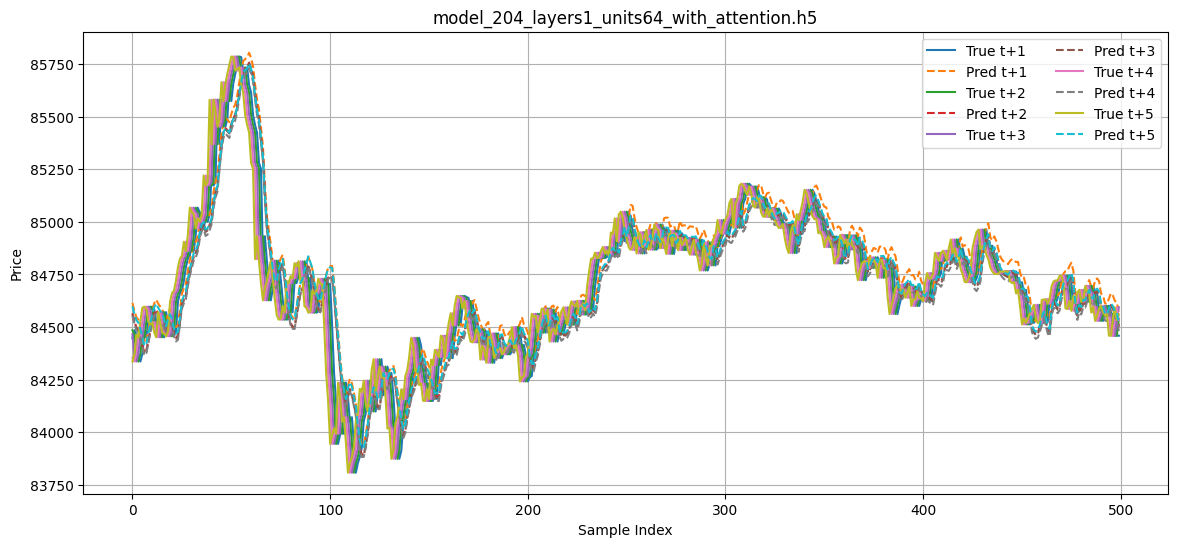

history_path: g:\ML\ML_Project\Bitcoin_Price_Prediction\notebooks\histories\history_204.json


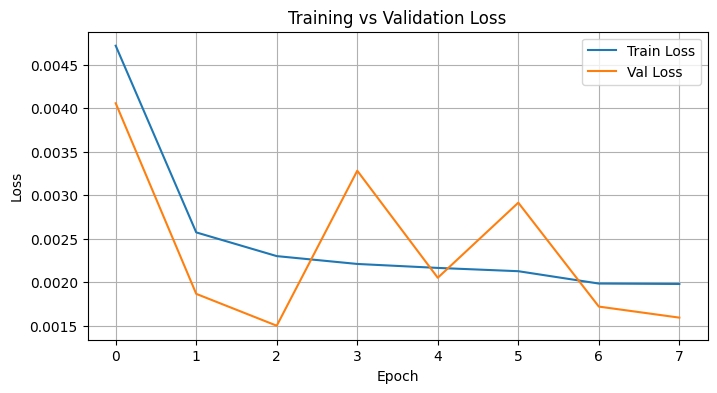

Step |        MSE       RMSE        MAE    MAPE%     R²
   1 | 15626.9033   125.0076   105.6523     0.10 0.9998
   2 |  8837.7158    94.0091    68.3325     0.06 0.9999
   3 | 12027.3799   109.6694    80.4543     0.08 0.9999
   4 | 16701.8379   129.2356    97.0416     0.09 0.9998
   5 | 16140.8213   127.0465    91.3847     0.09 0.9998


In [87]:
for r in results:
  print(r["result"][0])
  base_dir = os.getcwd()
  history_path = os.path.join(base_dir, "histories", r["history"])
  evaluate(y_test_all, r["result"], scaler=scaler_x, title=r["model_name"], history_path=history_path, future_steps=5)